In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_filled = pd.read_csv("../preprocessing/train_cleaned.csv")

target = 'SalePrice'
cols_to_exclude = [target, "Id"]
features = [col for col in df_filled.select_dtypes(include=[np.number]).columns 
            if col not in cols_to_exclude]

X = df_filled[features]
y = df_filled[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def shap_analysis_xgb(model, X_train, X_test, sample_size=100):
    print("Creating SHAP explainer:")
    explainer = shap.TreeExplainer(model)
    
    print(f"Calculating SHAP values for {sample_size} test samples:")
    X_test_sample = X_test.sample(n=min(sample_size, len(X_test)), random_state=42)
    shap_values = explainer.shap_values(X_test_sample)
    
    return explainer, shap_values, X_test_sample

In [2]:
# evaluation function
def evaluate_model(y_acc, y_pred):
    mae = mean_absolute_error(y_acc, y_pred)
    mse = mean_squared_error(y_acc, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_acc, y_pred)
    mape = np.mean(np.abs((y_acc - y_pred) / y_acc)) * 100
    rmse_pct = (rmse / y_acc.mean()) * 100

    # return instead of printing metrics
    return {
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'RMSE%': rmse_pct
    }

In [3]:
best_params = {'learning_rate': 0.07001802283701665, 'max_depth': 3, 'n_estimators': 841}

xgb_model = XGBRegressor(
    random_state=42,
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators']
)
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [4]:
explainer, shap_values, X_test_sample = shap_analysis_xgb(xgb_model, X_train, X_test, sample_size=100)

Creating SHAP explainer:
Calculating SHAP values for 100 test samples:


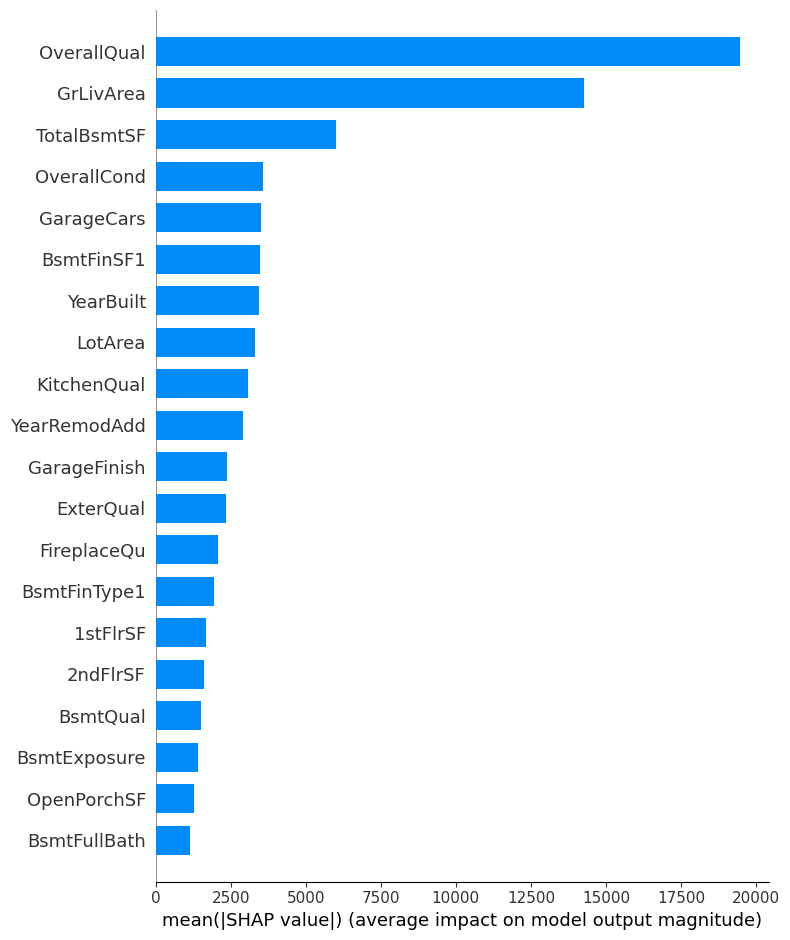

<Figure size 640x480 with 0 Axes>

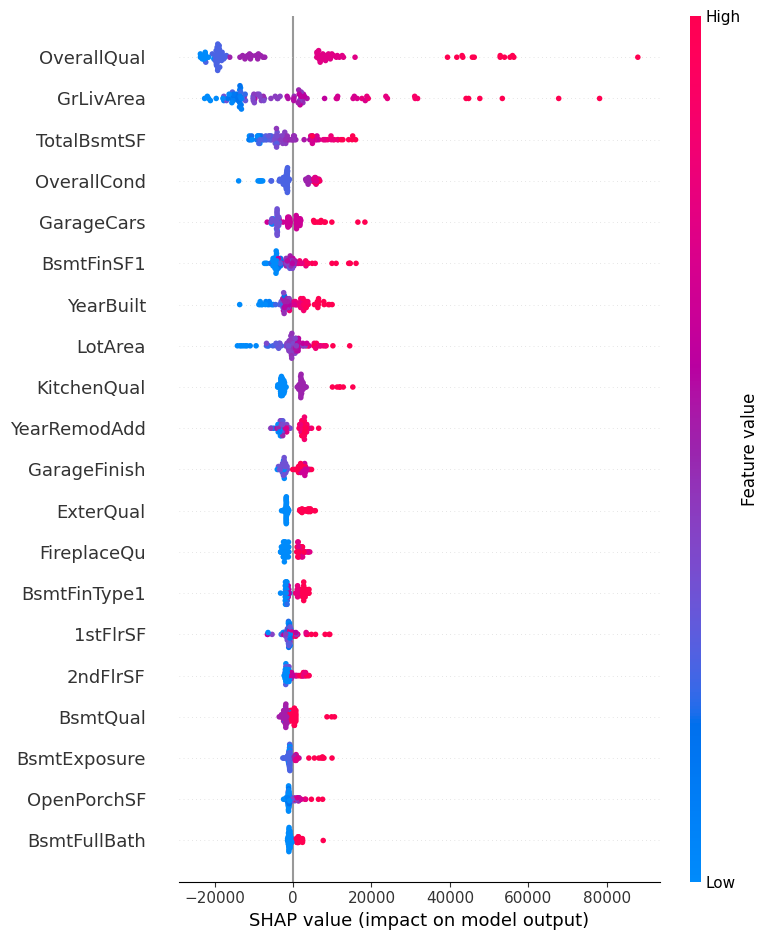

<Figure size 640x480 with 0 Axes>

In [6]:
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", max_display=20)
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, X_test_sample, max_display=20)
plt.tight_layout()
plt.show()

Creating SHAP explainer:
Calculating SHAP values for 100 test samples:


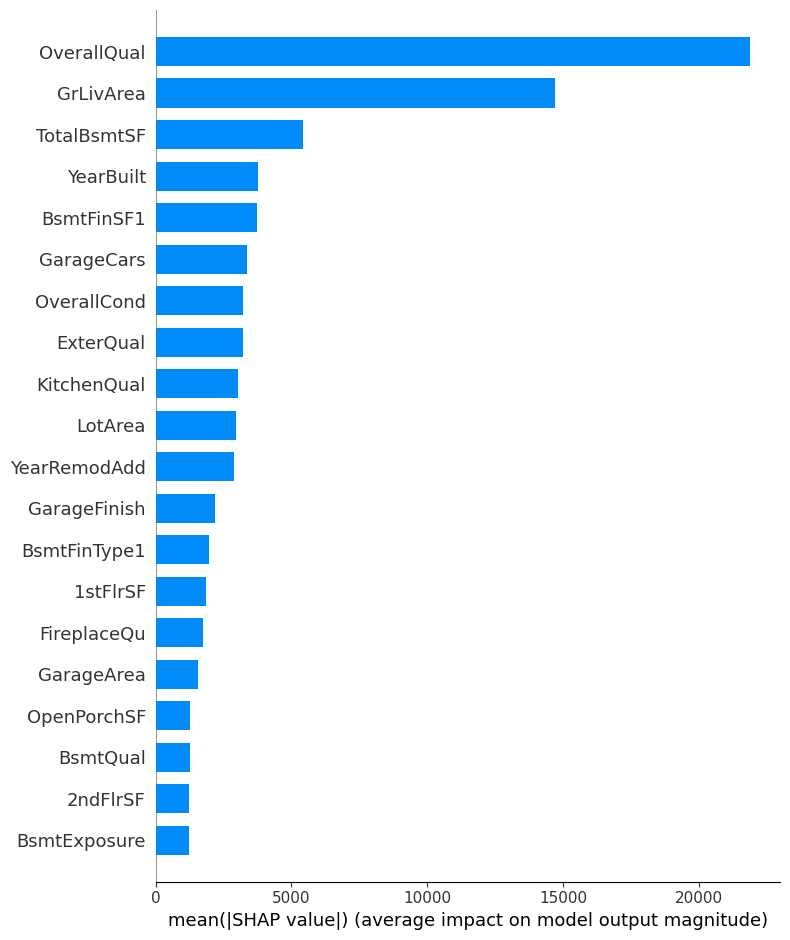

<Figure size 640x480 with 0 Axes>

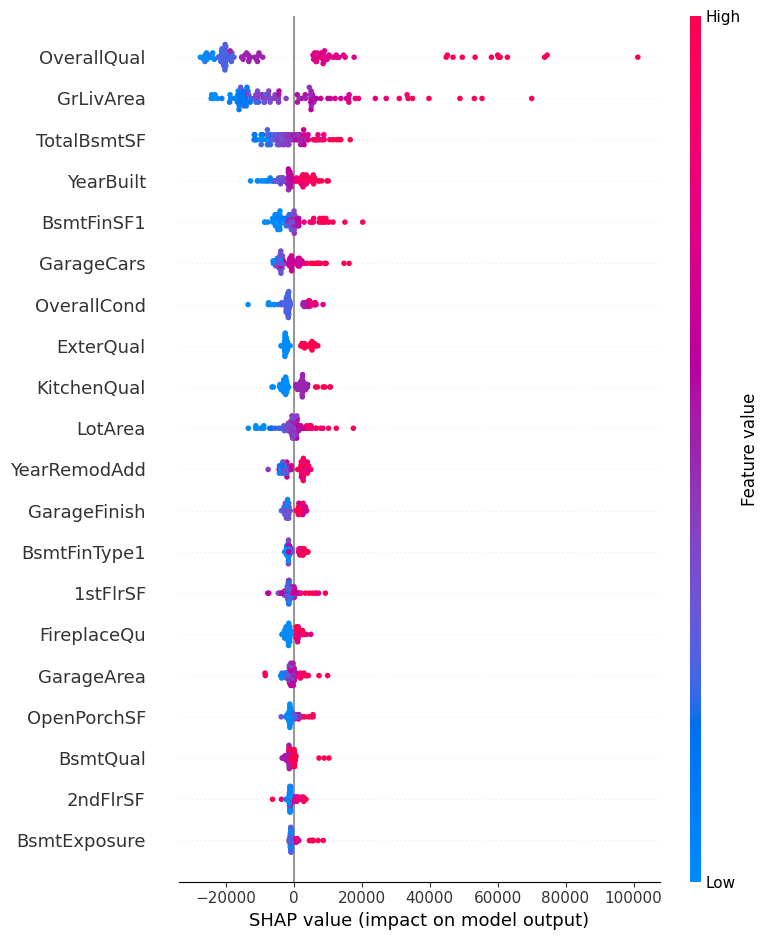

<Figure size 640x480 with 0 Axes>

In [8]:
def shap_analysis_gbr(model, X_train, X_test, sample_size=100):
    print("Creating SHAP explainer:")
    explainer = shap.TreeExplainer(model)
    
    print(f"Calculating SHAP values for {sample_size} test samples:")
    X_test_sample = X_test.sample(n=min(sample_size, len(X_test)), random_state=42)
    shap_values = explainer.shap_values(X_test_sample)
    
    return explainer, shap_values, X_test_sample

best_params_gbr = {'learning_rate': 0.05263727095314413, 'max_depth': 4, 'n_estimators': 799}

gbr_model = GradientBoostingRegressor(
    random_state=42,
    learning_rate=best_params_gbr['learning_rate'],
    max_depth=best_params_gbr['max_depth'],
    n_estimators=best_params_gbr['n_estimators']
)
gbr_model.fit(X_train, y_train)

explainer_gbr, shap_values_gbr, X_test_sample_gbr = shap_analysis_gbr(gbr_model, X_train, X_test, sample_size=100)

shap.summary_plot(shap_values_gbr, X_test_sample_gbr, plot_type="bar", max_display=20)
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values_gbr, X_test_sample_gbr, max_display=20)
plt.tight_layout()
plt.show()

In [9]:
def get_top_features_by_shap(shap_values, X_sample, top_n=150):
    feature_importance = np.abs(shap_values).mean(axis=0)
    feature_names = X_sample.columns
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    top_features = importance_df.head(top_n)['feature'].tolist()
    
    print(f"\nTop {top_n} features by SHAP importance:")
    print(importance_df.head(20))
    
    return top_features, importance_df

top_features_shap, shap_importance_df = get_top_features_by_shap(shap_values_gbr, X_test_sample_gbr, top_n=150)


Top 150 features by SHAP importance:
         feature    importance
6    OverallQual  21890.177424
28     GrLivArea  14709.836033
21   TotalBsmtSF   5425.559897
8      YearBuilt   3757.589190
17    BsmtFinSF1   3718.529517
42    GarageCars   3358.656936
7    OverallCond   3222.111703
11     ExterQual   3207.463517
35   KitchenQual   3040.149058
2        LotArea   2967.652171
9   YearRemodAdd   2903.277227
41  GarageFinish   2190.063371
16  BsmtFinType1   1982.448144
25      1stFlrSF   1842.377608
39   FireplaceQu   1752.128288
43    GarageArea   1545.859797
48   OpenPorchSF   1283.635750
13      BsmtQual   1266.530892
26      2ndFlrSF   1221.105199
15  BsmtExposure   1220.404763


In [10]:
def ablation_study_top_shap_features(X_train, X_test, y_train, y_test, shap_importance_df):
    results = {}
    best_params = {'learning_rate': 0.05263727095314413, 'max_depth': 4, 'n_estimators': 799}
    
    test_points = [50, 60, 70, 80, 90, 100]
    
    for n in test_points:
        top_n_features = shap_importance_df.head(n)['feature'].tolist()
        
        print(f"\nTraining with top {n} SHAP features...")
        
        X_train_subset = X_train[top_n_features]
        X_test_subset = X_test[top_n_features]
        
        gbr = GradientBoostingRegressor(
            random_state=42,
            learning_rate=best_params["learning_rate"],
            max_depth=best_params["max_depth"],
            n_estimators=best_params["n_estimators"]
        )
        gbr.fit(X_train_subset, y_train)
        y_gbr_pred = gbr.predict(X_test_subset)
        
        results[f'Top {n} SHAP features'] = evaluate_model(y_test, y_gbr_pred)
    
    return results

shap_feature_results = ablation_study_top_shap_features(X_train, X_test, y_train, y_test, shap_importance_df)
shap_feature_df = pd.DataFrame(shap_feature_results).T
shap_feature_df = shap_feature_df.sort_values('R²', ascending=False)
shap_feature_df


Training with top 50 SHAP features...

Training with top 60 SHAP features...

Training with top 70 SHAP features...

Training with top 80 SHAP features...

Training with top 90 SHAP features...

Training with top 100 SHAP features...


,R²,RMSE,MAE,MAPE,RMSE%
Top 80 SHAP features,0.914035,25678.416451,15766.274695,9.586599,14.358333
Top 90 SHAP features,0.913794,25714.327952,15881.257385,9.784727,14.378414
Top 70 SHAP features,0.912292,25937.354724,15838.635754,9.576471,14.503121
Top 100 SHAP features,0.911990,25982.005771,15877.832097,9.652177,14.528088
Top 60 SHAP features,0.908297,26521.552247,16032.007243,9.788442,14.829781
Top 50 SHAP features,0.907210,26678.249101,16276.328629,10.016470,14.917399


In [11]:
def ablation_study_top_shap_features_xgb(X_train, X_test, y_train, y_test, shap_importance_df):
    results = {}
    best_params = {'learning_rate': 0.07001802283701665, 'max_depth': 3, 'n_estimators': 841}
    
    test_points = [90, 100, 110, 120, 130, 140]
    
    for n in test_points:
        top_n_features = shap_importance_df.head(n)['feature'].tolist()
        
        print(f"\nTraining with top {n} SHAP features...")
        
        X_train_subset = X_train[top_n_features]
        X_test_subset = X_test[top_n_features]
        
        xgb = XGBRegressor(
            random_state=42,
            learning_rate=best_params["learning_rate"],
            max_depth=best_params["max_depth"],
            n_estimators=best_params["n_estimators"]
        )
        xgb.fit(X_train_subset, y_train)
        y_xgb_pred = xgb.predict(X_test_subset)
        
        results[f'Top {n} SHAP features'] = evaluate_model(y_test, y_xgb_pred)
    
    return results

top_features_shap_xgb, shap_importance_df_xgb = get_top_features_by_shap(shap_values, X_test_sample, top_n=150)

shap_feature_results_xgb = ablation_study_top_shap_features_xgb(X_train, X_test, y_train, y_test, shap_importance_df_xgb)
shap_feature_df_xgb = pd.DataFrame(shap_feature_results_xgb).T
shap_feature_df_xgb = shap_feature_df_xgb.sort_values('R²', ascending=False)
shap_feature_df_xgb


Top 150 features by SHAP importance:
         feature    importance
6    OverallQual  19464.011719
28     GrLivArea  14260.071289
21   TotalBsmtSF   6018.698242
7    OverallCond   3566.750244
42    GarageCars   3526.886963
17    BsmtFinSF1   3489.941162
8      YearBuilt   3440.185303
2        LotArea   3315.520020
35   KitchenQual   3081.730957
9   YearRemodAdd   2898.769043
41  GarageFinish   2381.004395
11     ExterQual   2336.333008
39   FireplaceQu   2092.802002
16  BsmtFinType1   1959.055786
25      1stFlrSF   1681.164062
26      2ndFlrSF   1621.863770
13      BsmtQual   1499.356567
15  BsmtExposure   1422.415283
48   OpenPorchSF   1287.778320
29  BsmtFullBath   1161.515625

Training with top 90 SHAP features...

Training with top 100 SHAP features...

Training with top 110 SHAP features...

Training with top 120 SHAP features...

Training with top 130 SHAP features...

Training with top 140 SHAP features...


,R²,RMSE,MAE,MAPE,RMSE%
Top 110 SHAP features,0.917408,25169.636310,15724.958984,9.457832,14.073844
Top 120 SHAP features,0.917146,25209.416653,15652.215820,9.414853,14.096088
Top 90 SHAP features,0.916953,25238.789194,15388.215820,9.244324,14.112512
Top 130 SHAP features,0.915035,25528.589150,15806.568359,9.523906,14.274556
Top 100 SHAP features,0.914101,25668.459712,15950.710938,9.649031,14.352766
Top 140 SHAP features,0.913588,25745.051563,15721.024414,9.436061,14.395593
